# Linear Regression Email Spam Classifier



### 1. Fetch Spam Assassin Data

HAM and SPAM represent non-spam and spam emails respectively.

In [1]:
import os 
import shutil
from modules.download import DataDownloader

In [ ]:
# Set up variables for downloading the data

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_FILE = "20030228_easy_ham.tar.bz2"
SPAM_FILE = "20030228_spam.tar.bz2"
HAM_URL = DOWNLOAD_ROOT + HAM_FILE
SPAM_URL = DOWNLOAD_ROOT + SPAM_FILE
SPAM_PATH = os.path.join("datasets", "spam") # datasets/spam
HAM_PATH = os.path.join("datasets", "ham") # datasets/ham

In [ ]:
# Create a DataDownloader object and download the files

data = DataDownloader(DOWNLOAD_ROOT, [HAM_FILE, SPAM_FILE])
data.download()

In [ ]:
# Modify file directory for convenience

sources = ["datasets/20030228_easy_ham.tar.bz2/easy_ham", "datasets/20030228_spam.tar.bz2/spam"]
for source in sources: 
    shutil.move(source, "datasets", copy_function=shutil.copytree)
    os.rmdir(os.path.dirname(source))
    # print(os.path.dirname(source))

----

### 2. Parsing Data

In [2]:
import email
import pandas as pd
import numpy as np

In [3]:
# Assemble pd database from parsing

content = []
# Loop through ham and spam
for ham_or_spam in os.listdir("datasets/"):
    for file in os.listdir("datasets/" + ham_or_spam):
        path_to_email = os.path.join("datasets", ham_or_spam, file)
        with open(path_to_email, "rb") as email_file:
            # Parse the email message using the email package
            message = email.message_from_binary_file(email_file)

            # Get the subject of the email
            subject = message["Subject"]

            # Get the sender of the email
            sender = message["From"]

            # Get the recipient(s) of the email
            recipients = message["To"]

            # Get the body of the email
            if message.is_multipart():
                for part in message.walk():
                    content_type = part.get_content_type()
                    content_disposition = str(part.get("Content-Disposition"))
                    if content_type == "text/plain" and "attachment" not in content_disposition:
                        body = part.get_payload()
                        break
            else:
                body = message.get_payload()
            
            content.append([subject, sender, body, recipients, 1 if ham_or_spam == "spam" else 0])


In [4]:
data_representation = np.array(content)
df = pd.DataFrame(data_representation, columns = ["Subject", "Sender", "Body", "Recipient", "Spam"])
df.head()

,Subject,Sender,Body,Recipient,Spam
0,Re: New Sequences Window,Robert Elz <kre@munnari.OZ.AU>,"Date: Wed, 21 Aug 2002 10:54:46 -05...",Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,0
1,[zzzzteana] RE: Alexander,Steve Burt <Steve_Burt@cursor-system.com>,"Martin A posted:\nTassos Papadopoulos, the Gre...","""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",0
2,[zzzzteana] Moscow bomber,"""Tim Chapman"" <timc@2ubh.com>",Man Threatens Explosion In Moscow \n\nThursday...,zzzzteana <zzzzteana@yahoogroups.com>,0
3,[IRR] Klez: The Virus That Won't Die,Monty Solomon <monty@roscom.com>,Klez: The Virus That Won't Die\n \nAlready the...,undisclosed-recipient: ;,0
4,Re: [zzzzteana] Nothing like mama used to make,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,"> in adding cream to spaghetti carbonara, whi...",zzzzteana@yahoogroups.com,0


----

### 3. Data Exploration

In [ ]:
df[df["Spam"]==1].head()

In [ ]:
print(df.iloc[0]["Body"].strip())

In [ ]:
print(df.iloc[30]["Body"])

In [ ]:
df["Body"].head()

In [ ]:
import re

for index, row in df.iterrows():
    if re.search("<html>", row["Body"]):
        print(row["Body"])
        print("~_~_~_~_~_~_~_~_~_~_~")
        print("~_~_~_~_~_~_~_~_~_~_~")
        print("NEW EMAIL")
        print("~_~_~_~_~_~_~_~_~_~_~")
        print("~_~_~_~_~_~_~_~_~_~_~")

---

### 4. Preprocessing

In [5]:
from modules.processing import Process
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

In [7]:
processed_text = []
for index, row in df.iterrows():
    tx = Process.clean_everything(df.loc[index]["Body"])
    tx = Process.stop_word_removal(tx)
    tx = Process.lem_words(tx)
    tx = Process.lower_case(tx)
    processed_text.append(tx)

df["Processed"] = processed_text
df.head()

,Subject,Sender,Body,Recipient,Spam,Processed
0,Re: New Sequences Window,Robert Elz <kre@munnari.OZ.AU>,"Date: Wed, 21 Aug 2002 10:54:46 -05...",Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,0,date wed # aug # # # # # chris garrigues email...
1,[zzzzteana] RE: Alexander,Steve Burt <Steve_Burt@cursor-system.com>,"Martin A posted:\nTassos Papadopoulos, the Gre...","""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",0,martin posted tassos papadopoulos greek sculpt...
2,[zzzzteana] Moscow bomber,"""Tim Chapman"" <timc@2ubh.com>",Man Threatens Explosion In Moscow \n\nThursday...,zzzzteana <zzzzteana@yahoogroups.com>,0,man threatens explosion moscow thursday august...
3,[IRR] Klez: The Virus That Won't Die,Monty Solomon <monty@roscom.com>,Klez: The Virus That Won't Die\n \nAlready the...,undisclosed-recipient: ;,0,klez virus wont die already prolific virus eve...
4,Re: [zzzzteana] Nothing like mama used to make,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,"> in adding cream to spaghetti carbonara, whi...",zzzzteana@yahoogroups.com,0,adding cream spaghetti carbonara effect pasta ...


#### Data Viz

Let us compare the word clouds for the emails before the processing and after the processing:

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

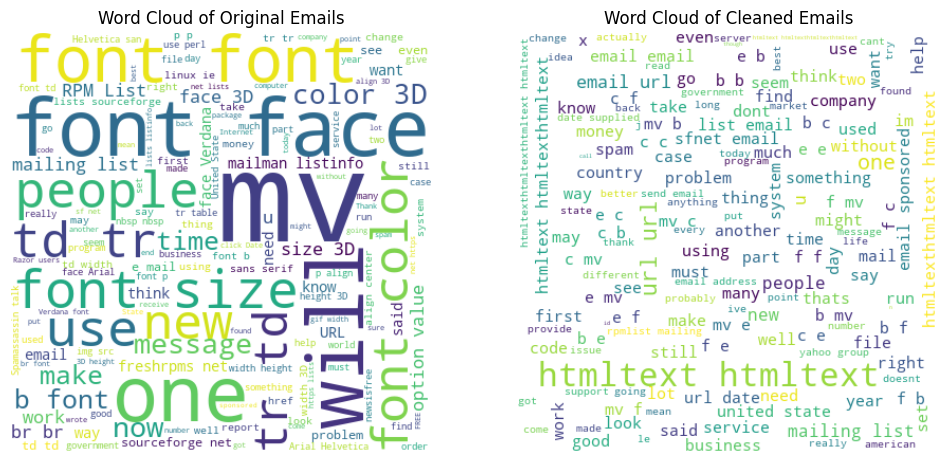

In [13]:
# Generate word cloud for original text
original_text = ' '.join(df['Body'])
wordcloud_original = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(original_text)

# Generate word cloud for cleaned text
cleaned_text = ' '.join(df['Processed'])
wordcloud_cleaned = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(cleaned_text)

# Create subplots to display word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wordcloud_original, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Original Emails')
axes[1].imshow(wordcloud_cleaned, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Cleaned Emails')

plt.show()


It would also be pretty interesting to compare the word clouds for the spam emails and the ham emails following the processing:

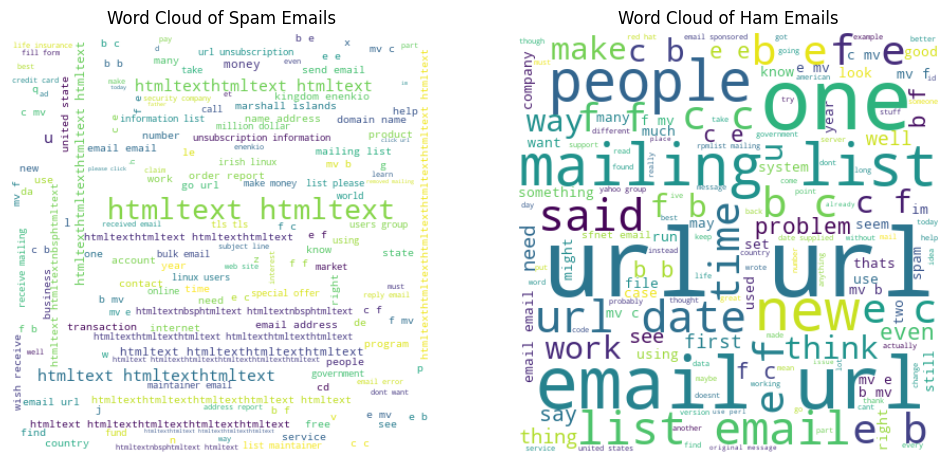

In [23]:
# Generate word cloud for spam text
spam_text = ' '.join(df[df['Spam'] == 1]['Processed'])
wordcloud_spam = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(spam_text)

# Generate word cloud for non-spam text
ham_text = ' '.join(df[df['Spam'] == 0]['Processed'])
wordcloud_ham = WordCloud(width=400, height=400, max_words=150, background_color='white').generate(ham_text)

# Create subplots to display word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wordcloud_spam, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Spam Emails')
axes[1].imshow(wordcloud_ham, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Ham Emails')

plt.show()

---

### 5. Training

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df["Body"], df["Spam"], test_size=0.2, random_state=42)